In [1]:
import pickle
import numpy as np
import os
import skimage
from skimage import transform as t
from skimage import exposure as e
from skimage import filters as f
from skimage import feature
from skimage.measure import regionprops #for center of mass
from tqdm import tqdm

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def find_centroid(image):
    # Get image shape
    rows, cols = image.shape

    # Calculate the moments
    m00 = np.sum(image)
    m10 = np.sum(np.arange(cols) * image)
    m01 = np.sum(np.arange(rows) * image.T)

    # Calculate centroid coordinates
    centroid_x = m10 / m00
    centroid_y = m01 / m00

    return centroid_x, centroid_y

In [ ]:
os.getcwd()

# Previous work on beam tomography 

Link for report with previous beam tomography:(link)[https://docs.google.com/document/d/1uOGDw6qHZKiGV28OnOs043JRSdri8LaaIsc8oYo4Qxg/edit#bookmark=id.4wuwfttv8kr]


# Description of measurements 

1. Acquisition #1 - 17.29.50 tomography.pkl (z from 14.6 to 16.6, PWM = 7%, exp = 1/40 000, 25us)
2. Acquisition #2 - 17.44.35 tomography.pkl (z from 14.6 to 17.6, PWM = 7%, exp = 1/40 000, 25us)

3. Acquisition #3 - 17.50.51 tomography.pkl (z from 14.6 to 18.6, PWM = 8%, exp = 1/40 000, 25us) - seems decoupled

4. Acquisition #4 - (re-coupled) - 17.56.48 tomography.pkl (z from 14.7 to 18.7)
5. Acquisition #5 - 18.02.48 tomography.pkl -same as acquisition 4, after rechecking coupling;


# List and load measurements 

In [2]:
filenames = [item for item in os.listdir() if ".pkl" in item]
filenames

['17.29.50 tomography.pkl',
 '17.44.35 tomography.pkl',
 '17.50.51 tomography.pkl',
 '17.56.48 tomography.pkl',
 '18.02.48 tomography.pkl']

In [5]:
filename = filenames[4]
print("Filename: ", filename)

#load data
tomo = Tomography(filename, (3,10))
tomo.load_data()

Filename:  18.02.48 tomography.pkl
Loaded
Tomography measurement:

        - Filename = 18.02.48 tomography.pkl

        - Number of beam rows = 3

        - Number of beam cols = 10

        - Z-spacing: 0.100mm

        - Number of cross sections: 40
        


In [ ]:
#load cross sections
for cross_sect_i in tomo.cross_sect_l:
    cross_sect_i.show_image()

In [6]:
peak_arr = tomo.find_geometry(angle_step = 0.5)

Extracting rotation angle for the lowest z cross section.


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [02:37<00:00,  1.14it/s]


Optimal rotation angle = 46.50deg
Updating the rotation angle and rotated image for each cross section.


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]

Extracting the grid spacing


In [11]:
peak_arr = arr

In [51]:
#label beams - line_id, col_id
kmeans_rows = KMeans(n_clusters = 3)
kmeans_rows.fit(peak_arr[:,0].reshape(-1,1)) #kmeans, 1 cluster per row
coords_rows = kmeans_rows.cluster_centers_
mean_delta_x = np.mean(np.diff(np.sort(coords_rows, axis = 0), axis = 0)) #spacing between rows

spacing = (mean_delta_x + mean_delta_y)*0.5

In [57]:
(145+137)/2.0*3.45

486.45000000000005

In [58]:
145*3.45

500.25

In [54]:
np.mean(np.diff(np.sort(coords_rows, axis = 0), axis = 0))

145.84999999999997

In [55]:
np.mean(np.diff(np.sort(coords_cols, axis = 0), axis = 0))

137.037037037037

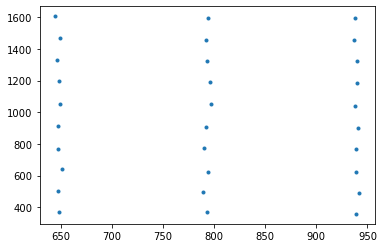

In [9]:
plt.plot(arr[:,0], arr[:,1], ".")

In [ ]:
tomo.cross_sect_l[0].image_rot is not None

In [ ]:
#label beams - line_id, col_id
kmeans_line = KMeans(n_clusters = 3)
kmeans_line.fit(peak_sorted_arr[:,0].reshape(-1,1))
line_id = kmeans_line.labels_

In [ ]:
plt.imshow(tomo.cross_sect_l[8].image_rot)

## Beam and cross section classes

In [59]:
class Tomography:
    def __init__(self, filename, shape):
        """
        Instantiate Tomography measurement.
        
        Args:
        1. Filename (str): File location and name
        2. Shape (tuple): (n_rows, n_cols), e.g (3,2)
        
        """
        
        self.filename = filename
        self.directory = os.getcwd()
        self.shape = shape
        
        self.cross_sect_image_l = None #list with cross section images
        self.cross_sect_z_l = None #list with cross section z coord
        self.n = None #number of cross sections
        self.z_diff = None #z difference between cross_sections;
                
        self.cross_sect_l = [] #list with cross section objects
        
        #geometric parameters --> find_geometry()
        self.pixel_size = 3.45*10**-6 #3.45um, for IS DMM 37UX256-ML-37U
    

    def __str__(self):
        return f"""Tomography measurement:\n
        - Filename = {self.filename}\n
        - Number of beam rows = {self.shape[0]:.0f}\n
        - Number of beam cols = {self.shape[1]:.0f}\n
        - Z-spacing: {self.z_diff:.3f}mm\n
        - Number of cross sections: {self.n:.0f}
        """

    def load_data(self):
        """
        Load:
        1. List with images of the cross sections
        2. List with values of z coordinate of each cross section
        """
        with open(self.filename, "rb") as file:
            data_dict = pickle.load(file)
        
        self.cross_sect_image_l = data_dict["img_store"]
        self.cross_sect_z_l = data_dict["coord_store"]
        self.n = len(self.cross_sect_image_l)
        self.z_diff = np.diff(np.array(self.cross_sect_z_l)).mean()
        
        for i in range(self.n):
            z_i = self.cross_sect_z_l[i]
            shape_i = self.shape
            image_i = self.cross_sect_image_l[i]
            cross_i = Cross_Section(z_i, shape_i, image_i)
            self.cross_sect_l.append(cross_i) #append cross_section object
        
        print("Loaded")
        print(self)
    

    def find_geometry(self, angle_step = 0.5):
        """
        1. Extract geometric parameters of grid, using the first cross-section (lowest z-value)
        2. Extract grid spacing;
        3. Pass the angle parameter and rotated image to the remaining cross sections;
        """
        
        print("Extracting rotation angle for the lowest z cross section.")
        cross_sect_i = self.cross_sect_l[0]
        opt_angle = cross_sect_i.find_rot_angle(angle_step = angle_step, plot = False)
        print(f"Optimal rotation angle = {opt_angle:.2f}deg")
        
        print("Updating the rotation angle and rotated image for each cross section.")
        for cross_sect_i in tqdm(self.cross_sect_l):
            cross_sect_i.rot_angle = opt_angle
            cross_sect_i.image_rot = t.rotate(cross_sect_i.image, cross_sect_i.rot_angle)
        
        print("Extracting the grid spacing")
        cross_sect_i = self.cross_sect_l[0]
        peak_arr = cross_sect_i.find_peaks(nrows = 3, ncols = 10, min_distance = 50)
        
        #label beams - line_id, col_id
        kmeans_rows = KMeans(n_clusters = 3)
        kmeans_rows.fit(peak_arr[:,0].reshape(-1,1)) #kmeans, 1 cluster per row
        coords_rows = kmeans_rows.cluster_centers_
        mean_delta_x = np.mean(np.diff(np.sort(coords_rows, axis = 0), axis = 0)) #spacing between rows
        spacing = mean_delta_x 

        print(f"Average spacing [px] between beams = {spacing:.2f}")
        print("Updating the spacing [px] for each cross section.")
        for cross_sect_i in tqdm(self.cross_sect_l):
            cross_sect_i.spacing = spacing


     
class Cross_Section:
    def __init__(self, z_coord, shape, image):
        self.z_coord = z_coord
        self.shape = shape # [n_rows x n_cols]
        self.image = image

        self.spacing = None #TO DO
        self.rot_angle = None
        self.image_rot = None #The main reference frame wil be rotated wrt the original
        
        self.beam_coord_l = None 
        self.beam_l = None #list with beam objects

    
    def __str__(self):
        return f"Cross section at z={self.z_coord:.2f}mm, with {self.shape[0]} rows and {self.shape[1]} cols."

    
    def show_image(self):
        f, ax = plt.subplots()
        x_range_mm = self.image.shape[1]*3.45*10**-3
        y_range_mm = self.image.shape[0]*3.45*10**-3
            
        plt.imshow(self.image, origin = "lower", extent = [0, x_range_mm, 0, y_range_mm])
        plt.xlabel("X [mm]")
        plt.ylabel("Y [mm]")
        plt.title(f"Z = {self.z_coord:.2f}mm")
        
        
    def find_rot_angle(self, angle_step = 0.5, plot = False):
        """
        Rotates cross section image, such that rows are horizontal
        and columns are vertical.
        """
        
        max_arr = list()
        angle_arr = np.arange(0, 90, angle_step)

        #image is rotated by different angles
        for angle_i in tqdm(angle_arr):
            image_t = t.rotate(self.image, angle_i) #rotate
            image_t = e.equalize_adapthist(image_t)
            #plt.imshow(image_t)

            horizontal_sum = np.sum(image_t, axis = 1) #sums along rows
            horizontal_max = np.max(horizontal_sum)
            max_arr.append(horizontal_max)

        angle_opt = angle_arr[np.argmax(max_arr)] #pick rotation angle that aligns all rows;
        self.rot_angle = angle_opt
        self.image_rot = t.rotate(self.image, angle_opt)
        
        if plot:
            plt.figure()
            plt.plot(angle_arr, max_arr, ".", color = "k")
            plt.plot(angle_arr, max_arr, color = "k")
            plt.xlabel("Angle [deg]")

            plt.axvline(x = angle_opt, linestyle = "--")
            plt.title(f"angle_opt = {angle_opt:.1f}deg")
    
        return angle_opt
    

    def find_peaks(self, nrows = 3, ncols = 10, min_distance = 50):
        """
        Find the coordinates of the beams in a cross-section;
        Updates the list self.beam_coord_l;
        
        Parameters:
        - rows (int): number of expected rows (horizontal)
        - columns (int): number of expected columns (vertical)
        - min_distance: minimum distance between the center of the beams;        
        
        """
        
        if self.image_rot is not None:
            image = self.image_rot
            exp_num_peaks = nrows * ncols

            peak_arr = feature.peak_local_max(image, num_peaks = exp_num_peaks, min_distance = min_distance)
            self.beam_coord_l = peak_arr
        else:
            print("First evaluate rotation angle of cross section")
            peak_arr = None
        
        return peak_arr
    
    
    def find_geom(self):
        """
        Finds geometric properties of beam disposition:
            1. off_x
            2. off_y
            3. spacing
            4. rot_angle = 
        """
        
        #procedure to find angle
        self.off_x = None
        self.off_y = None
        self.spacing = None
    
   

    def id_to_coord(id_x, id_y):
        """
        Converts the index of the beam to the respective coordinate
        e.g. first row, third column --> id_x = 1, id_y = 2
        
        Returns: coord_x, coord_y
        """
        
        
        return coord_x, coord_y
               

class Beam:
    def __init__(self, id_x, id_y, coord_x, coord_y):
        self.id_x = id_x
        self.id_y = id_y

        self.coord_x = coord_x #position of the centroid of the beam in the cross_section
        self.coord_y = coord_y

        self.image_list = None 
        self.coord_list = None #of centroid [x,y,z]
        self.diverg_full_angle = None
        self.tilt_x = None
        self.tilt_y = None
    

    def find_tilt(self):
        """
        Find tilt of the beam with respect to z axis.
        """
        self.tilt_x = None
        self.tilt_y = None
        
        
    def find_diverg(self):
        """
        Find beam full-angle divergence at 1/e^2
        """
        

## Collect [z, peak_arr, image_i] for all beams

In [ ]:
roi_x_width = 120
roi_y_width = 120
n_slices = len(images_list)

store_arr = [] #store store_z_arr, where each store_z_arr contains the info corresponding to a single height;

for z_id in range(0,n_slices,1):
    store_z_arr = []
    image_i = images_list[z_id]
    coord_i = coord_list[z_id]
    
    #Image transform
    image_t = t.rotate(image_i, 46.5) #rotate
    image_t = image_t[500:1050, 250:1750] #crop
    image_t = e.equalize_adapthist(image_t)
    
    #Detect peaks first iteration
    if z_id==0: #extract peaks in first z slice;
        peak_arr = feature.peak_local_max(image_t, num_peaks = 30, min_distance = 50)
    
        
    #Plotting
    fig, ax1 = plt.subplots(figsize = (14,4), ncols = 1)
    plt.title(f"coord = {coord_i:.2f}")
    
    ax1.imshow(image_t, interpolation = None)
    ax1.scatter(x = peak_arr[:,1], y = peak_arr[:,0], color = "r", s = 1)
       
    #Plotting individual beams
    for i, peak_i in enumerate(peak_arr):
        #calculate new position of peaks within roi
        peak_roi_i = image_t[int(peak_i[0] - roi_x_width/2) :int(peak_i[0] + roi_x_width/2),
                         int(peak_i[1] - roi_y_width/2) : int(peak_i[1] + roi_y_width/2)]
        
        centroid_x, centroid_y = find_centroid(peak_roi_i)
        print(peak_i, centroid_x, centroid_y)
        
        rect = Rectangle((peak_i[1]-roi_x_width/2,
                          peak_i[0]-roi_y_width/2),
                         roi_x_width, roi_y_width,
                         fill = False, color = "red")
        
        ax1.add_patch(rect)
        
        
        
        store_i = [z_id, peak_i, peak_roi_i]
        store_z_arr.append(store_i)
    
    store_arr.append(store_z_arr)
    
    

## Collect cross sections of the same beam for different z

For a given beam coordinate in the first layer (z=0), collect cross sections of the same beam at other z-values.

In [ ]:
# choose beam coords
# iterate over z values of storage
# at each z-level extract beam with closest coordinates to beam coords
# save chosen beam in beam_arr

beam_arr = []

#choose beam coords
b_id = 1 #beam_id

#storage scheme [z_id, beam_coords, image]
beam_coords = store_arr[z_id][b_id][1]

#pick closest coord in another layer
for z_id in range(len(store_arr)):
    coords_i = np.array([beam_i[1] for beam_i in store_arr[z_id]])
    dist = np.linalg.norm((coords_i - beam_coords), axis = 1)
    beam_idx = np.argmin(dist)
    beam_i = store_arr[z_id][beam_idx]
    beam_arr.append(beam_i)


###  Beam coordinates at different z values

In [ ]:
beam_coords_arr = [beam_i[1] for beam_i in beam_arr]
beam_coords_arr

In [ ]:
for z_slice in store_arr:
    for beam_i in z_slice:
        coords = beam_i[1]

In [ ]:

store_arr[z_id][b_id][1]

In [ ]:
plt.figure()
for i in store_arr:
    z_id, peak_i, image_i = i
    plt.figure()
    plt.title(peak_i)
    plt.imshow(image_i)


In [ ]:
col_id_arr = kmeans_col.labels_
for i, peak_i in enumerate(peak_arr):
    print(peak_i[0], col_id_arr[i] )

In [ ]:
#label beams - line_id, col_id
kmeans_line = KMeans(n_clusters = 3)
kmeans_line.fit(peak_sorted_arr[:,0].reshape(-1,1))
line_id = kmeans_line.labels_

In [ ]:
col_id

In [ ]:
kmeans_line.cluster_centers_


In [ ]:
line_id = kmeans_line.labels_

In [ ]:
np.sort(peak_arr)

In [ ]:
plt.figure()


In [ ]:
f, ax = plt.subplots()
plt.hist(data_dict["img_store"][-1].ravel(), bins = 25)
ax.set_yscale("log")

In [ ]:
list(range(0,5,2#label beams - line_id, col_id
kmeans_line = KMeans(n_clusters = 3)
kmeans_line.fit(peak_sorted_arr[:,0].reshape(-1,1))
line_id = kmeans_line.labels_a))